# Projeto Visão computacional - Reconhecimento da íris 

### objetivo:

- 1. Criar um modelo de treinamento usando a base de dados fornecida - melhorar a qualidade das imagens
- 2. obter a matriz de confusão do modelo 
- 3. analisar os resultados

***Nomes:*** Samuel Porto & Thalia Loiola

In [29]:
import os
import cv2
import pywt
import cv2 as cv
import numpy as np
from os import walk
import pandas as pd
import G6_iris_recognition
from matplotlib import pyplot as plt

In [3]:
# função de sharpen para imagens
# fonte: https://en.wikipedia.org/wiki/Unsharp_masking#Digital_unsharp_masking
def sharpen_image(img, kernel_size=(5, 5), sigma=1.5, amount=2.0, threshold=0):
    blurred = cv2.GaussianBlur(img, kernel_size, sigma)

    # formula para melhorar a nitidez da imagem 
    sharpened = float(amount + 1) * img - float(amount) * blurred

    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)

    if threshold > 0:
        low_contrast_mask = np.absolute(img - blurred) < threshold
        np.copyto(sharpened, img, where=low_contrast_mask)

    return sharpened

In [4]:
# função de melhora de brilho e contraste nas imagens
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

## Análise das características de uma imagem

Antes de tratar todas as imagens para o modelo de treinamento, fez-se uma análise individual de uma amostra afim de observar comportamentos específicos e possíveis melhoras na qualidade da imagem que poderiam ser aplicada as demais.

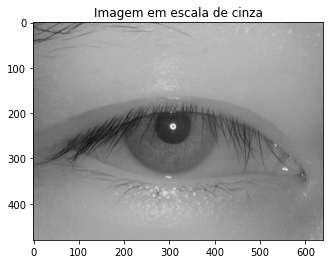

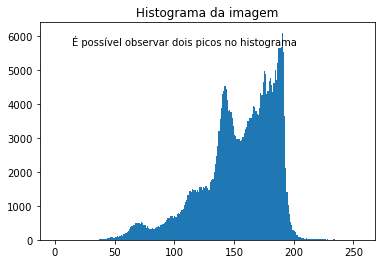

In [12]:
#Análise do histograma de uma imagem
image = cv2.imread('images/0000/0000_008.bmp')
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(img, 'gray')
plt.title('Imagem em escala de cinza')
plt.show()

plt.hist(img.ravel(),bins=255,range=[0,255]) # da pra ver melhor os dois picos no range=[100,225]
plt.title('Histograma da imagem')
plt.figtext(.2, .8, 'É possível observar dois picos no histograma')
plt.show()

É possível observar que a imagem possui dois picos de contraste, caso simplesmente equalizássemos a imagem esses dois picos ainda provocariam uma concentração de intensidades entre eles. Tendo isto em vista, foi utilizada a função CLAHE da biblioteca cv2 que remove picos de contraste para uma melhor equalização da imagem posteriormente, com o objetivo de evidenciar as características das imagens melhor, como mostrado abaixo:

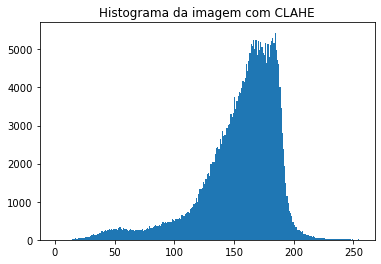

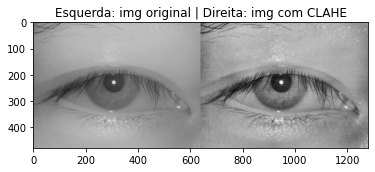

In [100]:
#Aplicação da função CLAHE na imagem desejada
clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
cl_img = clahe.apply(img)

# TRANSFORMAÇAO DO HISTOGRAMA PARA UM DE APENAS UM PICO
plt.hist(cl_img.ravel(),bins=255,range=[0,255])
plt.title('Histograma da imagem com CLAHE')
plt.show()

# imagem tradata
plt.imshow(np.hstack((img, cl_img)), 'gray')
plt.title('Esquerda: img original | Direita: img com CLAHE')
plt.show()

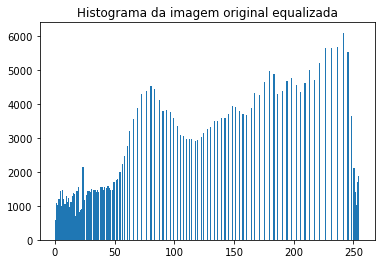

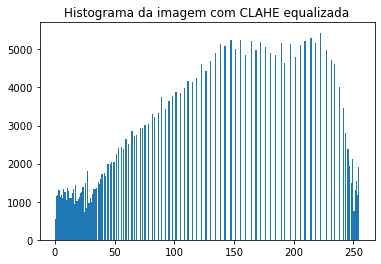

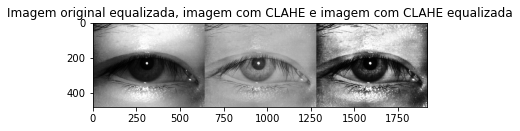

In [101]:
# equalizacao as imagens
img_equ = cv2.equalizeHist(img)

cl_img_equ = cv2.equalizeHist(cl_img)

plt.hist(img_equ.ravel(),bins=255,range=[0,255])
plt.title('Histograma da imagem original equalizada')
plt.show()

plt.hist(cl_img_equ.ravel(),bins=255,range=[0,255])
plt.title('Histograma da imagem com CLAHE equalizada')
plt.show()

plt.imshow(np.hstack((img_equ , cl_img, cl_img_equ)), 'gray')
plt.title('Imagem original equalizada, imagem com CLAHE e imagem com CLAHE equalizada')
plt.show()

É possível observar que a imagem que possui um contraste melhor e consegue evidenciar de maneira mais significativas os detalhes da íris, é a imagem do meio. A imagem do meio é a imagem original somente com o CLAHE, abaixo segue outras etapas de pré-processamento adotadas, com o intuito de deixar a imagem mais preparada, buscando um desempenho melhor no treinamento.

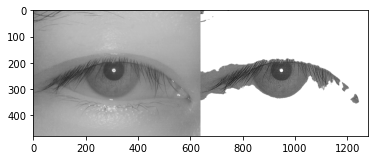

In [7]:
# IDEIA DE FOCAR SÓ NA IRIS - TENTAR MELHORAR ELA 
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])

img_s = cv2.filter2D(img, -1, kernel)

T, img_bin = cv.threshold(img_s.astype('uint8'),127,255,cv.THRESH_BINARY)

img_bin = cv.GaussianBlur(img_bin,(11,11),50)
new_img = img_s.copy()
rows, cols = new_img.shape

for l in range(rows):
    for c in range(cols):
        if img_bin[l][c] > T:
            new_img[l][c] = 255
            
plt.imshow(np.hstack((img, new_img)), 'gray')
plt.show()

In [8]:
def percorre_pastas(num_pasta):
    for (dirpath, dirnames, filenames) in walk("images/00{}".format(num_pasta)):
        for e in filenames:
            image = cv.imread("images/00{0}/{1}".format(num_pasta, e))
            img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # qual a magia que essa funcao faz?
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            cl_img = clahe.apply(img)

            directory ="images_processadas/images_processadas_{0}/00{0}/".format(num_pasta)

            if not os.path.exists(directory):
                os.makedirs(directory)

            filename = "images_processadas/images_processadas_{0}/00{0}/{1}".format(num_pasta, e)
            
            cv.imwrite(filename, cl_img)

In [9]:
# processamento para varias imagens
n_pastas = 15
for i in range(0, n_pastas):
    if i < 10:
        n ="0{}".format(i)
    else :
        n = i
        
    percorre_pastas(n)

In [12]:
# treinar em cada pasta             
for i in range(0, n_pastas):
    
    if i < 10:
        n ="0{}".format(i)
    
    else :
        if i == 12: 
            i = 13
        n = i
        
    valid_images = G6_iris_recognition.iris_model_train("./images_processadas/images_processadas_{0}".format(n),"model.pickle")
    
    directory ="valid_images/00{0}/".format(n)
    
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    for image in valid_images[1]:
        name = image.split('\\')[2]
                
        filename = "valid_images/00{0}/{1}".format(n, name)
        image = cv.imread("images_processadas/images_processadas_{0}/00{0}/{1}".format(n, name))
        
        cv.imwrite(filename, image)

directory_list ['./images_processadas/images_processadas_00\\0000']
name 0000
path_to_image ./images_processadas/images_processadas_00\0000\0000_000.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_001.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_002.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_003.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_004.bmp
rectangle expression1
path_to_image ./images_processadas/images_processadas_00\0000\0000_005.bmp
rectangle expression1
path_to_image ./images_processadas/images_processadas_00\0000\0000_006.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_007.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_008.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_009.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_010.bmp
path_to_image ./images_processadas/images_processadas

path_to_image ./images_processadas/images_processadas_03\0003\0003_010.bmp
locate expression 1 local variable 'east_mark' referenced before assignment
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image ./images_processadas/images_processadas_03\0003\0003_011.bmp
path_to_image ./images_processadas/images_processadas_03\0003\0003_012.bmp
path_to_image ./images_processadas/images_processadas_03\0003\0003_013.bmp
path_to_image ./images_processadas/images_processadas_03\0003\0003_014.bmp
path_to_image ./images_processadas/images_processadas_03\0003\0003_015.bmp
path_to_image ./images_processadas/images_processadas_03\0003\0003_016.bmp
path_to_image ./images_processadas/images_processadas_03\0003\0003_017.bmp
path_to_image ./images_processadas/images_processadas_03\0003\0003_018.bmp
path_to_image ./images_processadas/images_processadas_03\0003\0003_019.bmp
locate expression 1 local variable 'east_mark' referenced before assignment
rectangle expression2 not en

rectangle expression1
path_to_image ./images_processadas/images_processadas_06\0006\0006_003.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_004.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_005.bmp
rectangle expression1
path_to_image ./images_processadas/images_processadas_06\0006\0006_006.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_007.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_008.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_009.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_010.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_011.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_012.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_013.bmp
path_to_image ./images_processadas/images_processadas_06\0006\0006_014.bmp
path_to_image ./images_processadas/images_processadas_06

name 0010
path_to_image ./images_processadas/images_processadas_10\0010\0010_000.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_001.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_002.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_003.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_004.bmp
rectangle expression1
path_to_image ./images_processadas/images_processadas_10\0010\0010_005.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_006.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_007.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_008.bmp
rectangle expression1
path_to_image ./images_processadas/images_processadas_10\0010\0010_009.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_010.bmp
path_to_image ./images_processadas/images_processadas_10\0010\0010_011.bmp
path_to_image ./images_processadas/images_proc

locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image ./images_processadas/images_processadas_13\0013\0013_002.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image ./images_processadas/images_processadas_13\0013\0013_003.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image ./images_processadas/images_processadas_13\0013\0013_004.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image ./images_processadas/images_processadas_13\0013\0013_005.bmp
path_to_image ./images_processadas/images_processadas_13\0013\0013_006.bmp
locate expression 1 index 640 is out of bounds for axis 1

In [16]:
# agora chegou a hora da verdade. Apos selecionadas as imagens que funcionam para o nosso modelo vamos treinar apenas elas 
valid_images = G6_iris_recognition.iris_model_train("./valid_images","model.pickle")

directory_list ['./valid_images\\0000', './valid_images\\0001', './valid_images\\0002', './valid_images\\0003', './valid_images\\0004', './valid_images\\0005', './valid_images\\0006', './valid_images\\0007', './valid_images\\0008', './valid_images\\0009', './valid_images\\0010', './valid_images\\0011', './valid_images\\0013', './valid_images\\0014']
name 0000
path_to_image ./valid_images\0000\0000_000.bmp
path_to_image ./valid_images\0000\0000_001.bmp
path_to_image ./valid_images\0000\0000_002.bmp
path_to_image ./valid_images\0000\0000_003.bmp
path_to_image ./valid_images\0000\0000_006.bmp
path_to_image ./valid_images\0000\0000_007.bmp
path_to_image ./valid_images\0000\0000_008.bmp
path_to_image ./valid_images\0000\0000_009.bmp
path_to_image ./valid_images\0000\0000_010.bmp
path_to_image ./valid_images\0000\0000_011.bmp
path_to_image ./valid_images\0000\0000_012.bmp
path_to_image ./valid_images\0000\0000_013.bmp
path_to_image ./valid_images\0000\0000_014.bmp
path_to_image ./valid_image

path_to_image ./valid_images\0014\0014_010.bmp
path_to_image ./valid_images\0014\0014_011.bmp
path_to_image ./valid_images\0014\0014_012.bmp
path_to_image ./valid_images\0014\0014_013.bmp
path_to_image ./valid_images\0014\0014_014.bmp
path_to_image ./valid_images\0014\0014_015.bmp
path_to_image ./valid_images\0014\0014_016.bmp
path_to_image ./valid_images\0014\0014_017.bmp
path_to_image ./valid_images\0014\0014_018.bmp
path_to_image ./valid_images\0014\0014_019.bmp
train_db_model_path 14 14
[INFO] serializing encodings...
OK


In [23]:
valid_images

NameError: name 'valid_images' is not defined

In [84]:
# treinar em cada pasta  
n_pastas = 5

classificacao_certa = 0
classificacao_errada = 0
unmatch = 0

data = {'atual': [],
        'predito': []
        }

info = pd.DataFrame(data)

for i in range(0, n_pastas):
    
    if i < 10:
        n ="0{}".format(i)
    
    else :
        if i == 12: 
            i = 13
        n = i   
    
    for (dirpath, dirnames, filenames) in walk("./images_processadas/images_processadas_{0}/00{0}".format(n)):
        for e in filenames:
            classificado = G6_iris_recognition.iris_model_test("model.pickle","./images_processadas/images_processadas_{0}/00{0}/{1}".format(n,e))
            
            if classificado == "00{}".format(n):
                classificacao_certa += 1
            elif classificado == "unmatch":
                unmatch += 1
            else:
                classificacao_errada += 1
                
            info = info.append({'atual': "00{}".format(n), "predito": classificado}, ignore_index=True)

print(" certa:{0}\n errada:{1}\n unmatch:{2}".format(classificacao_certa, classificacao_errada, unmatch))

rectangle expression1
rectangle expression1
rectangle expression1
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 local variable 'east_mark' referenced before assignment
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectan

In [85]:
info

,atual,predito
0,0000,0007
1,0000,0007
2,0000,0007
3,0000,0013
4,0000,unmatch
...,...,...
95,0004,unmatch
96,0004,unmatch
97,0004,unmatch
98,0004,unmatch


<ipython-input-90-7c364d9bc8da>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = pessoa == df['predito']
<ipython-input-90-7c364d9bc8da>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['atual'] = pessoa == df['atual']


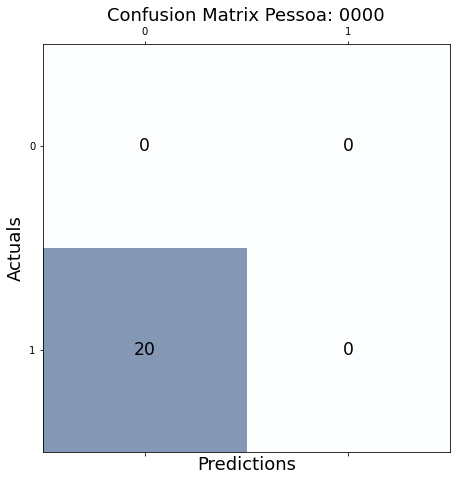

<ipython-input-90-7c364d9bc8da>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = pessoa == df['predito']
<ipython-input-90-7c364d9bc8da>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['atual'] = pessoa == df['atual']


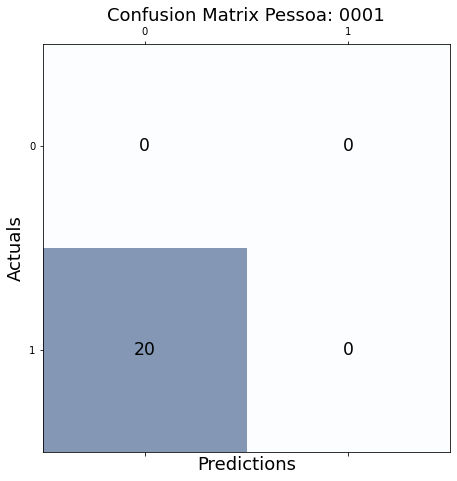

<ipython-input-90-7c364d9bc8da>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = pessoa == df['predito']
<ipython-input-90-7c364d9bc8da>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['atual'] = pessoa == df['atual']


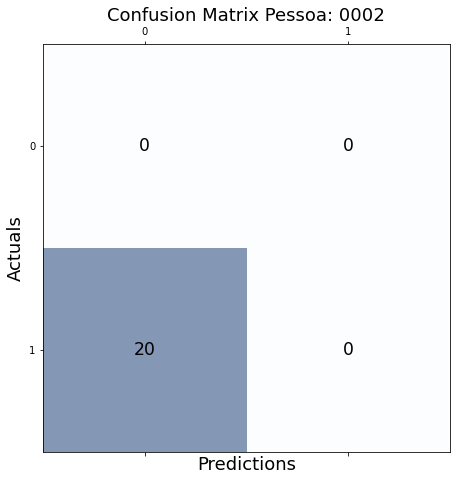

<ipython-input-90-7c364d9bc8da>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = pessoa == df['predito']
<ipython-input-90-7c364d9bc8da>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['atual'] = pessoa == df['atual']


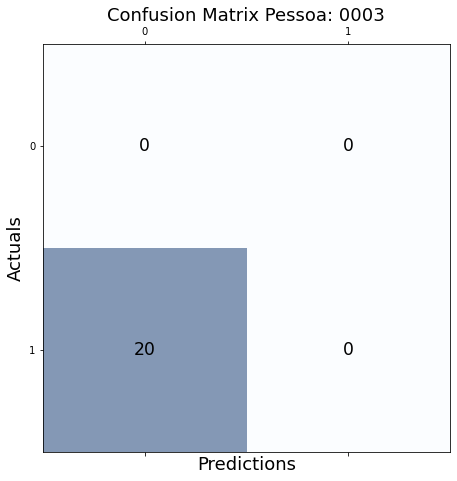

<ipython-input-90-7c364d9bc8da>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = pessoa == df['predito']
<ipython-input-90-7c364d9bc8da>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['atual'] = pessoa == df['atual']


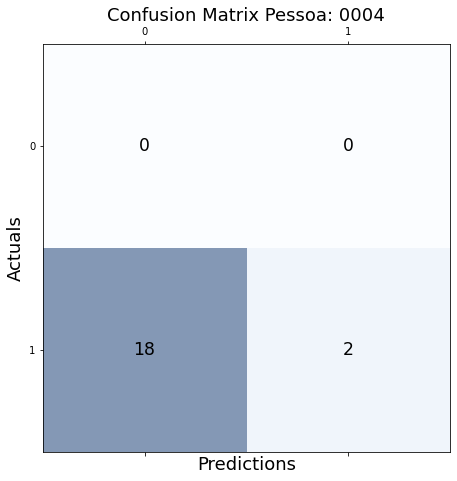

In [90]:
dataframe = info.copy()

pessoas = list(dataframe.atual.unique())

pessoa_data = []

for pessoa in pessoas:
    df = dataframe[dataframe['atual'] == pessoa]

    df['pred'] = pessoa == df['predito']

    df['atual'] = pessoa == df['atual']

    conf_matrix = confusion_matrix(y_true=df.atual, y_pred=df.pred)

    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix Pessoa: {}'.format(pessoa), fontsize=18)
    plt.show()

In [94]:
dataframe['pred'] = dataframe['atual'] == dataframe['predito']

dataframe[dataframe.atual == '0000']

,atual,predito,pred
0,0000,0007,False
1,0000,0007,False
2,0000,0007,False
3,0000,0013,False
4,0000,unmatch,False
5,0000,unmatch,False
6,0000,0013,False
7,0000,0013,False
8,0000,0013,False
9,0000,0013,False


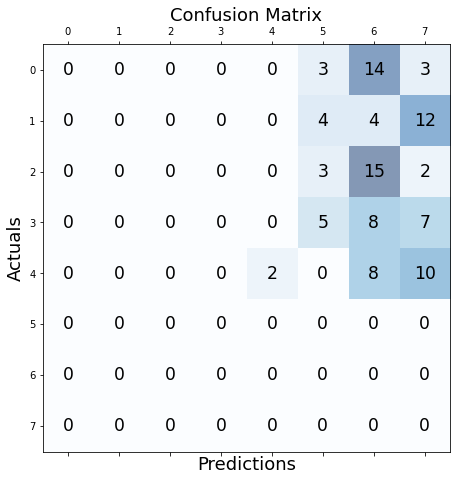

In [93]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true=dataframe.atual, y_pred=dataframe.predito)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.5)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()